In [15]:
#Importing packages
import praw
import requests
import pandas as pd
import json
from datetime import datetime, timedelta, date

#Configs for API keys
from config import reddit_client_id
from config import reddit_secret_key
from config import reddit_user_name
from config import reddit_password
from config import yahoo_api_key

#Graphs, math, and stats
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import linregress
from scipy import stats

In [16]:
#Base URL for rapidapi yahoo finance
yahoo_base_url = "https://yahoo-finance127.p.rapidapi.com/price/"

#API key and host
headers_yahoo = {
    "X-RapidAPI-Key": yahoo_api_key,
    "X-RapidAPI-Host": "yahoo-finance127.p.rapidapi.com"
}

#get input from user for stock symbol / empty list 
company_names = []
stock_symbol = str(input("Enter stock symbol to search"))

#------------------------------------------------------------------------TO-DO - Add error handling for when ticker is not found
#Grabbing URL, stock symbol, converting to JSON
yahoo_response = requests.get(yahoo_base_url + stock_symbol, headers=headers_yahoo).json()
#yahoo_response

#Add longname as search term for reddit
company_names.append(yahoo_response["longName"])

#Add stock symbol as search term for reddit
company_names.append(stock_symbol)

#Get alternate company names to use for reddit search
msg = f"{stock_symbol}'s LongName is {company_names[0]}.  Add another search term and press Enter, or press Cancel when done'"

#While loop to add company name
while True:
    response = str(input(msg))
    if len(response)> 0:
        company_names.append(response)
    else:
        break

#remove duplicates from company_names
reddit_search_list = pd.Series(company_names).drop_duplicates().tolist()

In [17]:
#Checking reponse from rapid API
print(yahoo_response)

{'symbol': 'TSLA', 'twoHundredDayAverageChangePercent': {'raw': 0.017038725, 'fmt': '1.70%'}, 'averageAnalystRating': '2.8 - Hold', 'fiftyTwoWeekLowChangePercent': {'raw': 1.2510431, 'fmt': '125.10%'}, 'language': 'en-US', 'earningsTimestampEnd': {'raw': 1706529600, 'fmt': '2024-01-29', 'longFmt': '2024-01-29T07:00'}, 'regularMarketDayRange': {'raw': '228.2 - 236.9', 'fmt': '228.20 - 236.90'}, 'epsForward': {'raw': 3.56, 'fmt': '3.56'}, 'regularMarketDayHigh': {'raw': 236.9, 'fmt': '236.90'}, 'twoHundredDayAverageChange': {'raw': 3.8394928, 'fmt': '3.84'}, 'twoHundredDayAverage': {'raw': 225.3392, 'fmt': '225.34'}, 'askSize': {'raw': 11, 'fmt': '11', 'longFmt': '11'}, 'bookValue': {'raw': 16.818, 'fmt': '16.82'}, 'marketCap': {'raw': 728540708864, 'fmt': '728.541B', 'longFmt': '728,540,708,864'}, 'fiftyTwoWeekHighChange': {'raw': -70.11131, 'fmt': '-70.11'}, 'fiftyTwoWeekRange': {'raw': '101.81 - 299.29', 'fmt': '101.81 - 299.29'}, 'fiftyDayAverageChange': {'raw': -4.6963043, 'fmt': '-

In [18]:
#Grabbing function method to access reddit
auth = requests.auth.HTTPBasicAuth(reddit_client_id,reddit_secret_key)
data = {
    'grant_type': 'password',
    'username': reddit_user_name,
    'password': reddit_password
}
headers = {'User-Agent': 'redditapi/1'}
#Grabbing posts from reddit
res = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth, data=data, headers=headers)
token12 = res.json()['access_token']
headers = {**headers, **{'Authorization': f'bearer {token12}'}}
headers
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)
#Creating empty list to store reddit posts
reddit_posts = []

#Activating Praw
reddit = praw.Reddit(
    client_id=reddit_client_id,
    client_secret=reddit_secret_key,
    password = data['password'],
    user_agent=f"testscript by u/{data['username']}",
    username = data['username'],
)


#-----------------------------------------------------------TO-DO: Do we need to set a different limit or search criteria?
#Using praw to get subreddit easily
for term in reddit_search_list:
    for submission in reddit.subreddit("wallstreetbets").search(term, limit=1000, sort="new"):
        sub_create_utc = datetime.utcfromtimestamp(submission.created_utc).strftime('%Y-%m-%d') 
        reddit_posts.append({"search term": term,
                             "title": submission.title,
                            "upvotes": submission.score,
                            "num_comments": submission.num_comments,
                            "date_utc": sub_create_utc})
#Creating Dataframe
reddit_df = pd.DataFrame(reddit_posts)
reddit_df.drop_duplicates(subset=["title"],keep="first",inplace=True)
reddit_df

,search term,title,upvotes,num_comments,date_utc
0,"Tesla, Inc.",JPOW looking at job data today,8,1,2023-12-08
1,"Tesla, Inc.",Where is all the damn gain porn?,35,38,2023-12-07
2,"Tesla, Inc.",TSLA Institutional Ownership Over Time.,9,5,2023-11-28
3,"Tesla, Inc.",Tesla insiders had perfect timing with selling...,90,27,2023-11-20
4,"Tesla, Inc.",$1.2k —> $10.7k thanks to $TSLA,524,69,2023-11-19
...,...,...,...,...,...
707,Tesla,"Tesla stock drops on margin concerns, Musk war...",18,6,2023-07-20
708,Tesla,Tesla may keep cutting prices in 'turbulent ti...,149,95,2023-07-20
709,Tesla,"Musk, Tesla board to return $735M after being ...",579,60,2023-07-20
712,Tesla,Should I be worried about Tesla earnings tomor...,506,54,2023-07-18


In [19]:
#Prepping Yahoo Rapid API for JSON print
url = f"https://yahoo-finance127.p.rapidapi.com/historic/{stock_symbol}/1d/1000d"
#Printing yahoo Rapid API 
yahoo_response2 = requests.get(url,headers=headers_yahoo).json()
yahoo_response2

{'meta': {'currency': 'USD',
  'symbol': 'TSLA',
  'exchangeName': 'NMS',
  'instrumentType': 'EQUITY',
  'firstTradeDate': 1277818200,
  'regularMarketTime': 1702484901,
  'gmtoffset': -18000,
  'timezone': 'EST',
  'exchangeTimezoneName': 'America/New_York',
  'regularMarketPrice': 229.261,
  'chartPreviousClose': 27.948,
  'priceHint': 2,
  'currentTradingPeriod': {'pre': {'timezone': 'EST',
    'start': 1702458000,
    'end': 1702477800,
    'gmtoffset': -18000},
   'regular': {'timezone': 'EST',
    'start': 1702477800,
    'end': 1702501200,
    'gmtoffset': -18000},
   'post': {'timezone': 'EST',
    'start': 1702501200,
    'end': 1702515600,
    'gmtoffset': -18000}},
  'dataGranularity': '1d',
  'range': '1000d',
  'validRanges': ['1d',
   '5d',
   '1mo',
   '3mo',
   '6mo',
   '1y',
   '2y',
   '5y',
   '10y',
   'ytd',
   'max']},
 'timestamp': [1577197800,
  1577370600,
  1577457000,
  1577716200,
  1577802600,
  1577975400,
  1578061800,
  1578321000,
  1578407400,
  1578

In [20]:
#Empty list to store yahoo finance data
yahoo_finance3 = []
#Creating loop to create add data to list
x = 0
for date_data in yahoo_response2['timestamp']:
    formatted_date = datetime.utcfromtimestamp(yahoo_response2['timestamp'][x]).strftime('%Y-%m-%d') 
    
    yahoo_finance3.append({"Symbol": yahoo_response2['meta']["symbol"],
                        "date_utc": formatted_date,
                        "Open": yahoo_response2['indicators']['quote'][0]['open'][x],
                        "Volume": yahoo_response2['indicators']['quote'][0]['volume'][x],
                        "High": yahoo_response2['indicators']['quote'][0]['high'][x],
                        "Close": yahoo_response2['indicators']['quote'][0]['close'][x],
                        "Low": yahoo_response2['indicators']['quote'][0]['low'][x]})
    
    x += 1

#Creating dataframe from list
yahoo_finance3_df = pd.DataFrame(yahoo_finance3)

#Finding Daily Change price from "close" and "open" price
yahoo_finance3_df["Daily Change"] = yahoo_finance3_df["Close"] - yahoo_finance3_df["Open"]
print(yahoo_finance3_df)


    Symbol    date_utc        Open     Volume        High       Close  \
0     TSLA  2019-12-24   27.890667  120820500   28.364668   28.350000   
1     TSLA  2019-12-26   28.527332  159508500   28.898666   28.729334   
2     TSLA  2019-12-27   29.000000  149185500   29.020666   28.691999   
3     TSLA  2019-12-30   28.586000  188796000   28.600000   27.646667   
4     TSLA  2019-12-31   27.000000  154285500   28.086000   27.888666   
..     ...         ...         ...        ...         ...         ...   
995   TSLA  2023-12-07  241.550003  107142300  244.080002  242.639999   
996   TSLA  2023-12-08  240.270004  102980100  245.270004  243.839996   
997   TSLA  2023-12-11  242.740005   97913900  243.440002  239.740005   
998   TSLA  2023-12-12  238.550003   95176300  238.990005  237.009995   
999   TSLA  2023-12-13  234.190002   54118621  236.899994  229.261002   

            Low  Daily Change  
0     27.512667      0.459333  
1     28.423332      0.202002  
2     28.407333     -0.3080

In [21]:
#Merging the reddit data and yahoo finance data
merged_df = pd.merge(reddit_df,yahoo_finance3_df)
merged_df

,search term,title,upvotes,num_comments,date_utc,Symbol,Open,Volume,High,Close,Low,Daily Change
0,"Tesla, Inc.",JPOW looking at job data today,8,1,2023-12-08,TSLA,240.270004,102980100,245.270004,243.839996,239.270004,3.569992
1,Tesla,Why NIO Inc is Undervalued,0,72,2023-12-08,TSLA,240.270004,102980100,245.270004,243.839996,239.270004,3.569992
2,"Tesla, Inc.",Where is all the damn gain porn?,35,38,2023-12-07,TSLA,241.550003,107142300,244.080002,242.639999,236.979996,1.089996
3,tsla,Only took me 9 days to lose 290k yoloing on TS...,1509,390,2023-12-07,TSLA,241.550003,107142300,244.080002,242.639999,236.979996,1.089996
4,tsla,Call/put extensive value.,8,12,2023-12-07,TSLA,241.550003,107142300,244.080002,242.639999,236.979996,1.089996
...,...,...,...,...,...,...,...,...,...,...,...,...
507,Tesla,Grabbing calls for RIVN earnings,42,55,2023-08-08,TSLA,247.449997,96642200,250.919998,249.699997,245.009995,2.250000
508,Tesla,"280,000 Tesla vehicles under investigation for...",34,21,2023-08-01,TSLA,266.260010,83166000,266.470001,261.070007,260.250000,-5.190002
509,Tesla,Meta plans launch of AI bots with different pe...,11,18,2023-08-01,TSLA,266.260010,83166000,266.470001,261.070007,260.250000,-5.190002
510,Tesla,Tesla stock downgraded by UBS,93,35,2023-07-24,TSLA,255.850006,136508500,269.850006,269.059998,254.119995,13.209991


In [22]:
#Removing huge outliers from reddit upvotes and comments
merged_df = merged_df[(np.abs(stats.zscore(merged_df['upvotes'])) < 3)]
merged_df = merged_df[(np.abs(stats.zscore(merged_df['num_comments'])) < 3)]
merged_df

,search term,title,upvotes,num_comments,date_utc,Symbol,Open,Volume,High,Close,Low,Daily Change
0,"Tesla, Inc.",JPOW looking at job data today,8,1,2023-12-08,TSLA,240.270004,102980100,245.270004,243.839996,239.270004,3.569992
1,Tesla,Why NIO Inc is Undervalued,0,72,2023-12-08,TSLA,240.270004,102980100,245.270004,243.839996,239.270004,3.569992
2,"Tesla, Inc.",Where is all the damn gain porn?,35,38,2023-12-07,TSLA,241.550003,107142300,244.080002,242.639999,236.979996,1.089996
3,tsla,Only took me 9 days to lose 290k yoloing on TS...,1509,390,2023-12-07,TSLA,241.550003,107142300,244.080002,242.639999,236.979996,1.089996
4,tsla,Call/put extensive value.,8,12,2023-12-07,TSLA,241.550003,107142300,244.080002,242.639999,236.979996,1.089996
...,...,...,...,...,...,...,...,...,...,...,...,...
507,Tesla,Grabbing calls for RIVN earnings,42,55,2023-08-08,TSLA,247.449997,96642200,250.919998,249.699997,245.009995,2.250000
508,Tesla,"280,000 Tesla vehicles under investigation for...",34,21,2023-08-01,TSLA,266.260010,83166000,266.470001,261.070007,260.250000,-5.190002
509,Tesla,Meta plans launch of AI bots with different pe...,11,18,2023-08-01,TSLA,266.260010,83166000,266.470001,261.070007,260.250000,-5.190002
510,Tesla,Tesla stock downgraded by UBS,93,35,2023-07-24,TSLA,255.850006,136508500,269.850006,269.059998,254.119995,13.209991


0      238.407912
1      238.407912
2      238.203206
3      238.203206
4      238.203206
          ...    
507    238.298956
508    237.684836
509    237.684836
510    239.203626
511    239.203626
Name: Daily Change, Length: 489, dtype: float64
0.08254295525383958
y = 0.08x +238.11
The r-value is: 1.351298369039196e-06


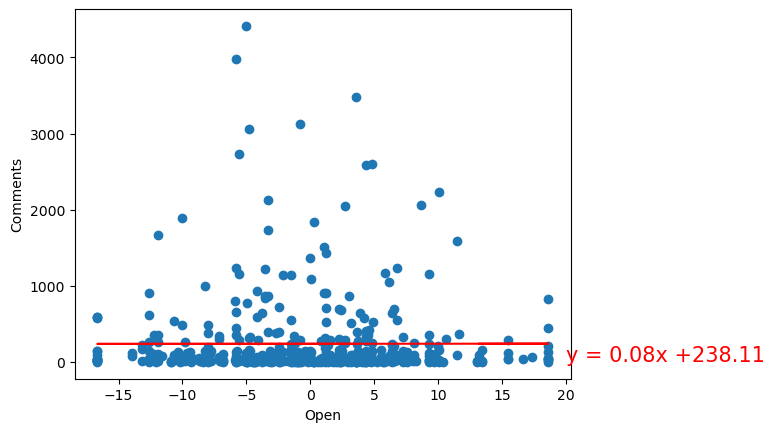

In [29]:
# Linear regression on Reddit upvotes and comments, yahoo prices
x_values = merged_df['Daily Change']
y_values = merged_df['upvotes']

# Perform a linear regression on X and Y
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept
print(regress_values)
print(slope)
#Creating line equation
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
print(line_eq)
# Create Plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Label plot and annotate the line equation
plt.xlabel('Open')
plt.ylabel('Comments')
plt.annotate(line_eq,(20,5),fontsize=15,color="red")

# Print r value
print(f"The r-value is: {rvalue**2}")

# Show plot
plt.show()

In [33]:

# yahoo_finance = []

# yahoo_finance.append({"Symbol": yahoo_response["symbol"],
#                         "Day_Range_raw": yahoo_response["regularMarketDayRange"]["raw"],
#                         "Market_Price": yahoo_response["regularMarketPrice"]["raw"],
#                         "Company_Name": yahoo_response["longName"]})

# yahoo_finance_df = pd.DataFrame(yahoo_finance)
# yahoo_finance_df.head()


In [30]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# import pandas as pd

# # Sample DataFrame with a column of sentences
# # Assuming merged_df is already defined

# sentences_list = []

# for index, row in merged_df.iterrows():
#     sentences_list.append(row['title'])

# # Creating a DataFrame from the list of sentences
# df = pd.DataFrame({"sentences": sentences_list})

# # Combining all sentences into a single string
# text = " ".join(sentence for sentence in df["sentences"])

# # Generating the word cloud
# wordcloud = WordCloud(width=800, height=800,
#                       background_color='white',
#                       min_font_size=10).generate(text)

# # Displaying the WordCloud
# plt.figure(figsize=(8, 8), facecolor=None)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.tight_layout(pad=0)
# plt.show()

In [31]:
# import matplotlib.pyplot as plt
# # Plot the charts and apply some styling
# danger_drop, = plt.plot(merged_df['Daily Change'], merged_df['upvotes'], color="red", label="Danger Drop")
# railgun, = plt.plot(merged_df['Daily Change'], merged_df['num_comments'], color="blue", label="RailGun")

In [32]:
# Example of the Spearman's Rank Correlation Test
from scipy.stats import spearmanr
data1 = merged_df['upvotes']
data2 = merged_df['num_comments']
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably independent')
else:
 print('Probably dependent')

stat=0.719, p=0.000
Probably dependent
